# ÖDEV 1: PCA yardımı ile Classification,

Bu ödevde "Credit Risk Prediction" veri setini kullanacağız. Amacımız, verinin boyut sayısını düşürerek olabildiğince yüksek accuracy değerini alabilmek. Aşağıda verinin okunma ve temizlenme kısmını hazırlayıp vereceğim. Devamında ise yapmanız gerekenler:

1. PCA kullanarak verinin boyutunu düşürmek
    * Önce explained varience ratio değerini inceleyerek veriyi kaç boyuta düşürebileceğini kontrol et.
    * Daha sonra farklı boyutlarda denemeler yaparak boyutu düşürülmüş verileri elde et.
2. Classification modellerini dene
    * Logistic Regression
    * Random Forest
    * ve eğer istersen herhangi bir modelle daha

İsteğe bağlı olarak, verinin boyutunu düşürmek için diğer yöntemleri de kullanıp en yüksek accuracy değerini almayı deneyebilirsin.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df: pd.DataFrame = pd.read_csv('data/credit_risk_dataset.csv')

In [28]:
print(df.isnull().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [29]:
# Null değerleri sütun ortalaması ile dolduruyoruz
df["person_emp_length"].fillna(df["person_emp_length"].median(), inplace=True)
df["loan_int_rate"].fillna(df["loan_int_rate"].median(), inplace=True)

In [30]:
df.duplicated().sum()

165

In [31]:
df.drop_duplicates(inplace=True)

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32416.0,27.747008,6.354100,20.00,23.00,26.00,30.00,144.00
person_income,32416.0,66091.640826,62015.580269,4000.00,38542.00,55000.00,79218.00,6000000.00
person_emp_length,32416.0,4.768880,4.090411,0.00,2.00,4.00,7.00,123.00
loan_amnt,32416.0,9593.845632,6322.730241,500.00,5000.00,8000.00,12250.00,35000.00
loan_int_rate,32416.0,11.014662,3.083050,5.42,8.49,10.99,13.11,23.22
loan_status,32416.0,0.218688,0.413363,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32416.0,0.170250,0.106812,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32416.0,5.811297,4.059030,2.00,3.00,4.00,8.00,30.00


In [33]:
# Outlier temizliği
df = df[df['person_age']<=100]
df = df[df['person_emp_length'] <= 60]
df = df[df['person_income']<=4e6]

In [34]:
# Kategorik verileri alıyoruz ve one hot encoding haline getiriyoruz
cat_cols = pd.DataFrame(df[df.select_dtypes(include=['object']).columns])
cat_cols.columns

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [35]:
encoded_cat_cols = pd.get_dummies(cat_cols)
df.drop(df.select_dtypes(include=['object']).columns, axis=1,inplace=True)
df = pd.concat([df,encoded_cat_cols], axis=1)

In [36]:
X = df.drop('loan_status', axis=1).values
y = df['loan_status'].values

In [37]:
# Verileri train ve test olarak ikiye ayırıyoruz

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(1, test_size=0.1)
train_idx, test_idx = next(split.split(X, y))
train_x = X[train_idx]
test_x = X[test_idx]

train_y = y[train_idx]
test_y = y[test_idx]

## Kolay gelsin!

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x)

x_train_scaler = scaler.transform(train_x)
x_test_scaler = scaler.transform(test_x)

In [39]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train_scaler)

cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]

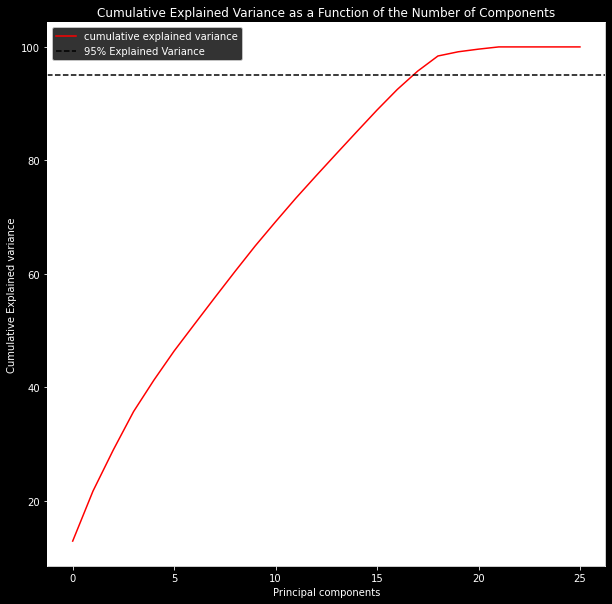

In [40]:
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.set_facecolor("white")
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')

In [41]:
from sklearn.decomposition import PCA

pca = PCA(.95) 
pca.fit(x_train_scaler)

x_train_pca = pca.transform(x_train_scaler)
x_test_pca = pca.transform(x_test_scaler)

## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(n_jobs = -1)
logistic_regression.fit(x_train_pca, train_y)

LogisticRegression(n_jobs=-1)

In [43]:
print('Training set score: {:.4f}'.format(logistic_regression.score(x_train_pca, train_y)))
print('Test set score: {:.4f}'.format(logistic_regression.score(x_test_pca, test_y)))

Training set score: 0.8640
Test set score: 0.8571


## Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier 

dTree = DecisionTreeClassifier().fit(x_train_pca, train_y)

In [46]:
print('Training set score: {:.4f}'.format(dTree.score(x_train_pca, train_y)))
print('Test set score: {:.4f}'.format(dTree.score(x_test_pca, test_y)))

Training set score: 1.0000
Test set score: 0.8500


## Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier().fit(x_train_pca, train_y)

In [48]:
print('Training set score: {:.4f}'.format(rf_model.score(x_train_pca, train_y)))
print('Test set score: {:.4f}'.format(rf_model.score(x_test_pca, test_y)))

Training set score: 1.0000
Test set score: 0.9062
